In [1]:
import numpy as np
import pandas as pd
from scipy.special import iv, kv
from matplotlib import pyplot as plt
from PIL import Image

In [2]:
# Bessel 1st kind modified functions
I0 = lambda x: iv(0, x)
I1 = lambda x: iv(1, x)

# Bessel 2nd kind modified functions
K0 = lambda x: kv(0, x)
K1 = lambda x: kv(1, x)

In [3]:
def load_constants():
    return Image.open('constants-a.png')

In [4]:
M = 10
m = 1.5
r1 = 0.5
phi = 0.2
q0, q1 = 2, 4
omega = 10
pi = np.math.pi

def J(M=M, m=m):
    return 2 * pow(M, 2) / (1 + pow(m, 2))

def A(M=M, m=m):
    return np.sqrt(J(M=M, m=m))

@np.vectorize
def r2(z=0.5, phi=phi):
    """outer cylinder radius equation"""
    return 1 + phi * np.math.cos(2 * pi * z)

@np.vectorize
def q(t, q0=q0, q1=q1, omega=omega):
    return q0 + q1 * np.math.sin(omega * t)

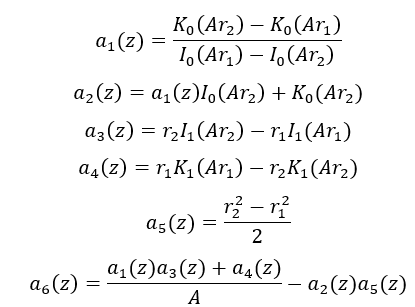

In [5]:
load_constants()

In [6]:
@np.vectorize
def a1(z=0.5, phi=phi, M=M, m=m):
    r2z = r2(z, phi=phi)
    part_1 = K0(A(M=M, m=m) * r2z) - K0(A(M=M, m=m) * r1)
    part_2 = I0(A(M=M, m=m) * r1) - I0(A(M=M, m=m) * r2z)
    return part_1 / part_2

@np.vectorize
def a2(z=0.5, phi=phi, M=M, m=m):
    r2z = r2(z, phi=phi)
    return a1(z, M=M, m=m) * I0(A(M=M, m=m) * r2z) + K0(A(M=M, m=m) * r2z)

@np.vectorize
def a3(z=0.5, phi=phi, M=M, m=m):
    r2z = r2(z, phi=phi)
    return r2z * I1(A(M=M, m=m) * r2z) - r1 * I1(A(M=M, m=m) * r1)

@np.vectorize
def a4(z=0.5, phi=phi, M=M, m=m):
    r2z = r2(z, phi=phi)
    return r1 * K1(A(M=M, m=m) * r1) - r2z * K1(A(M=M, m=m) * r2z)

@np.vectorize
def a5(z=0.5, phi=phi, M=M, m=m):
    r2z = r2(z, phi=phi)
    return (pow(r2z, 2) - pow(r1, 2)) / 2

@np.vectorize
def a6(z=0.5, phi=phi, M=M, m=m):
    part_1 = a1(z, phi=phi, M=M, m=m) * a3(z, phi=phi, M=M, m=m) + a4(z, phi=phi, M=M, m=m)
    part_2 = a5(z, phi=phi, M=M, m=m)
    return part_1 * a2(z, phi=phi, M=M, m=m) / A(M=M, m=m) - part_2

In [7]:
@np.vectorize
def c2(z=0.5, t=1, phi=phi, M=M, m=m, q0=q0, q1=q1, omega=omega):
    part_1 = 2 * dpdz(z=z, t=t, phi=phi, M=M, m=m, q0=q0, q1=q1, omega=omega)
    part_2 = a2(z, phi=phi, M=M, m=m) * J(M=M, m=m)
    return part_1 / part_2

@np.vectorize
def c1(z=0.5, t=1, phi=phi, M=M, m=m, q0=q0, q1=q1):
    return a1(z, phi=phi, M=M, m=m) * c2(z=z, t=t, phi=phi, M=M, m=m, q0=q0, q1=q1)

In [8]:
@np.vectorize
def dpdz(z=0.5, t=1, phi=phi, M=M, m=m, omega=omega, q0=q0, q1=q1, q_v=None):
#     return 1
    if q_v is None:
        q_v = q(t, q0=q0, q1=q1, omega=omega)
        
    part_1 = a2(z=z, phi=phi, M=M, m=m) * J(M=M, m=m) / (2 * a6(z=z, phi=phi, M=M, m=m))
    part_2 = (q_v / (2 * pi)) + 2 * a5(z=z, phi=phi, M=M, m=m) / J(M=M, m=m)
    return part_1 * part_2

In [23]:
nz = 5
nt = 300
zs = np.linspace(0, 1, nz)
ts = np.linspace(0, 2, nt)
dps = np.zeros((nz, nt))

for (i, ti) in enumerate(ts):
    dps[:,i] = dpdz(z=zs, t=ti, q0=0.2, q1=0.4)

In [24]:
dfdp1 = pd.DataFrame(dps).transpose()
dfdp1.head(2)

,0,1,2,3,4
0,-0.032426,-0.045248,-0.082759,-0.045248,-0.032426
1,-0.035123,-0.049622,-0.091986,-0.049622,-0.035123


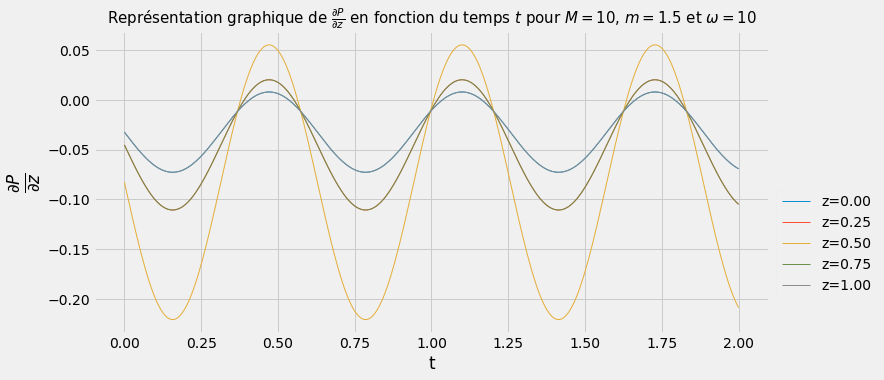

In [25]:
with plt.style.context('fivethirtyeight'):
    for i in np.arange(0, nz):
        z = zs[i]
        plt.plot(ts, dps[i, :], label=f'z={z:.2f}', linewidth=1)
    plt.legend(framealpha=0.1, bbox_to_anchor=(1, 0.5))
    fig = plt.gcf()
    fig.set_size_inches(12.5, 5.5)
    frac = r'\frac{\partial P}{\partial z}'
    plt.xlabel('t')
    plt.ylabel(f'${frac}$', fontsize=24)
    sp = r'\hspace{0.25}'
    t = fr'Représentation graphique de ${frac}$ en fonction du temps $t$ pour $M=10$, $m=1.5$ et $\omega=10$'
    plt.title(t, fontsize=15)
    plt.tight_layout()
#     plt.savefig('figs/pressure-gradient-newtonian-beta-small.png', transparent=True)

In [110]:
nz2 = 100
nt2 = 5
zs2 = np.linspace(0, 1, nz2)
ts2 = np.linspace(0, 0.5, 2*nt2)
dps2 = np.zeros((nz2, 2*nt2))

for (i, t) in enumerate(ts2):
    dps2[:, i] = dpdz(z=zs2, t=t, omega=10)

dfdp2 = pd.DataFrame(dps2).transpose()
dfdp2.head(2)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.213971,-0.214139,-0.214644,-0.215488,-0.216675,-0.218209,-0.220097,-0.222348,-0.224969,-0.227972,...,-0.227972,-0.224969,-0.222348,-0.220097,-0.218209,-0.216675,-0.215488,-0.214644,-0.214139,-0.213971
1,-0.426748,-0.427093,-0.428130,-0.429863,-0.432300,-0.435450,-0.439327,-0.443947,-0.449329,-0.455496,...,-0.455496,-0.449329,-0.443947,-0.439327,-0.435450,-0.432300,-0.429863,-0.428130,-0.427093,-0.426748


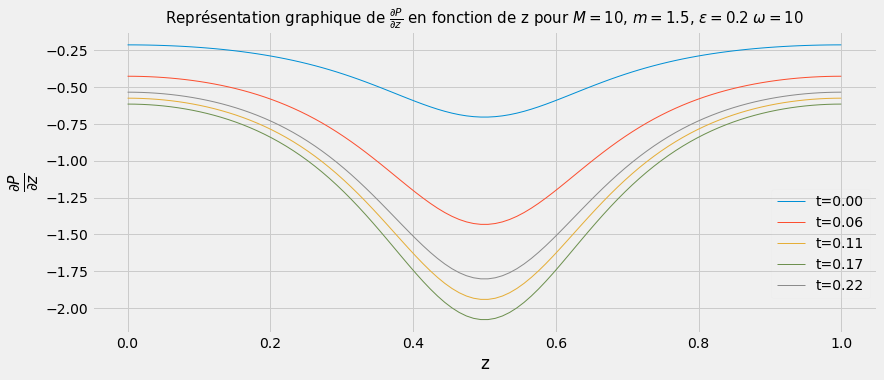

In [112]:
with plt.style.context('fivethirtyeight'):
    for i in np.arange(0, nt2):
        t = ts2[i]
        plt.plot(zs2, dps2[:, i], label=f't={t:.2f}', linewidth=1)
    plt.legend(framealpha=0.1, bbox_to_anchor=(1, 0.5))
    fig = plt.gcf()
    fig.set_size_inches(12.5, 5.5)
    plt.tight_layout()
    frac = r'$\frac{\partial{P}}{\partial{z}}$'
    plt.xlabel('z')
    plt.ylabel(frac, fontsize=22)
    plt.title(fr'Représentation graphique de {frac} en fonction de z pour $M=10$, $m=1.5$, $\epsilon=0.2$ $\omega=10$', fontsize=15)
    plt.tight_layout()
#     plt.savefig('figs/pressure-gradient-newtonian-beta-small-z.png', transparent=True)


In [26]:
@np.vectorize
def w(r, z=0.5, t=1, phi=phi, M=M, m=m, q0=q0, q1=q1, omega=omega):
    part_1 = c1(z, t, phi=phi, M=M, m=m, q0=q0, q1=q1) * I0(A(M=M, m=m) * r)
    part_2 = c2(z, t, phi=phi, M=M, m=m, q0=q0, q1=q1) * K0(A(M=M, m=m) * r)
    part_3 = 2 * dpdz(z, t, phi=phi, M=M, m=m, q0=q0, q1=q1, omega=omega) / J(M=M, m=m)
    return part_1 + part_2 - part_3 - 1

In [27]:
nr = 50
nt = 10
rs = np.linspace(r1, r2(), nr)
ts = np.linspace(0, 10, nt)
ws = np.zeros((50, 50))

for (i, ti) in enumerate(ts):
    ws[:, i] = w(r=rs, t=ti)

In [28]:
df_1 = pd.DataFrame(ws).transpose()
df_1.head(2)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-1.0,-0.999048,-0.998159,-0.997327,-0.996553,-0.995831,-0.995161,-0.994540,-0.993965,-0.993436,...,-0.993955,-0.994473,-0.995027,-0.995618,-0.996247,-0.996914,-0.997622,-0.998371,-0.999163,-1.0
1,-1.0,-1.000902,-1.001746,-1.002533,-1.003268,-1.003952,-1.004587,-1.005176,-1.005720,-1.006222,...,-1.005730,-1.005238,-1.004713,-1.004153,-1.003558,-1.002925,-1.002254,-1.001544,-1.000793,-1.0


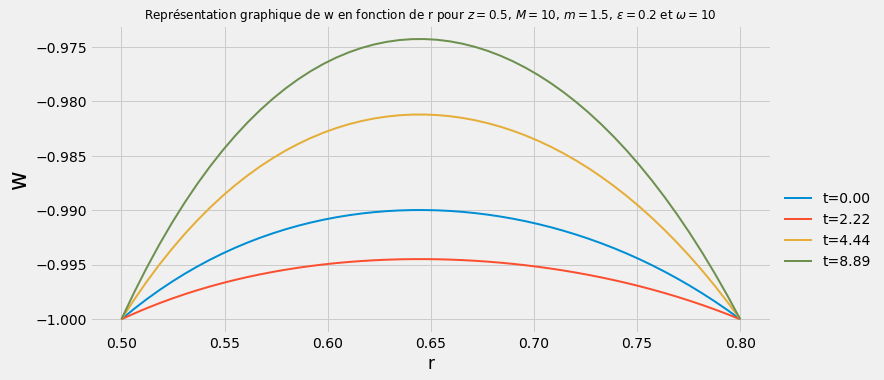

In [29]:
with plt.style.context('fivethirtyeight'):
    for i in range(5):
        if np.all(ws[:, i * 2] <= -1):
            continue
        t = ts[i * 2]
        plt.plot(rs, ws[:, i * 2], label=f't={t:.2f}', linewidth=2)

    fig = plt.gcf()
    fig.set_size_inches(12.5, 5.5)
    plt.legend(framealpha=0.1, bbox_to_anchor=(1, 0.5))
    plt.xlabel('r')
    plt.ylabel('w', fontsize=24)
    plt.title(r'Représentation graphique de w en fonction de r pour $z=0.5$, $M=10$, $m=1.5$, $\epsilon=0.2$ et $\omega=10$', fontsize=10)
    plt.tight_layout()
    plt.savefig('figs/axial-velocity-newtonian-beta-small.png', transparent=True)

In [130]:
# axial velocity profile with different values of Hartmann number
nr = 50
rs = np.linspace(r1, r2(), nr)
ws_1 = w(rs, t=2.1, M=5)
ws_2 = w(rs, t=2.1, M=10)
ws_3 = w(rs, t=2.1, M=15)
ws_4 = w(rs, t=2.1, M=20)

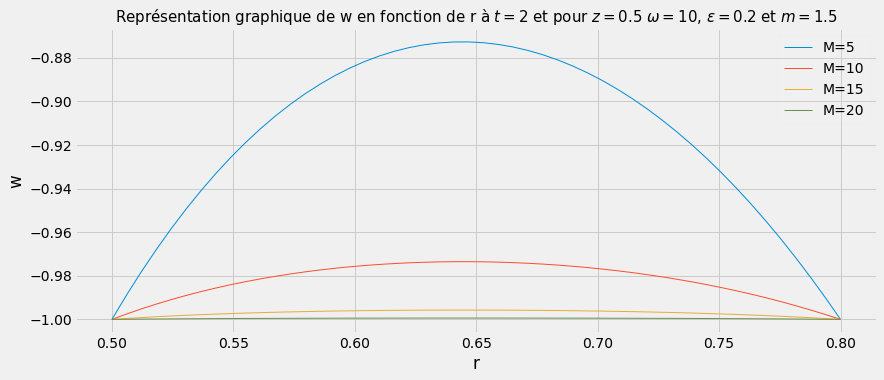

In [158]:
with plt.style.context('fivethirtyeight'):
    plt.plot(rs, ws_1, linewidth=1, label='M=5')
    plt.plot(rs, ws_2, linewidth=1, label='M=10')
    plt.plot(rs, ws_3, linewidth=1, label='M=15')
    plt.plot(rs, ws_4, linewidth=1, label='M=20')
    
    fig = plt.gcf()
    fig.set_size_inches((12.5, 5.5))
    plt.legend(framealpha=0.1)
    
    plt.xlabel('r')
    plt.ylabel('w')
    plt.title(r'Représentation graphique de w en fonction de r à $t=2$ et pour $z=0.5$ $\omega=10$, $\epsilon=0.2$ et $m=1.5$', fontsize=15)
    
    plt.tight_layout()
    plt.savefig('figs/axial-velocity-newtonian-beta-small-Hartmann.png', transparent=True)

In [48]:
# axial velocity profile with different values of Hartmann number
nr = 50
rs = np.linspace(r1, r2(), nr)
ws_5 = w(rs, t=2, m=1)
ws_6 = w(rs, t=2, m=1.5)
ws_7 = w(rs, t=2, m=2)
ws_8 = w(rs, t=2, m=0)

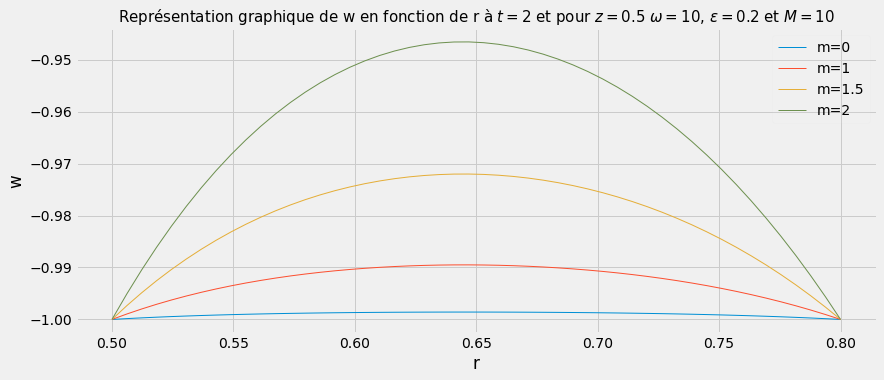

In [51]:
with plt.style.context('fivethirtyeight'):
    plt.plot(rs, ws_8, linewidth=1, label='m=0')
    plt.plot(rs, ws_5, linewidth=1, label='m=1')
    plt.plot(rs, ws_6, linewidth=1, label='m=1.5')
    plt.plot(rs, ws_7, linewidth=1, label='m=2')
    
    fig = plt.gcf()
    fig.set_size_inches((12.5, 5.5))
    plt.legend(framealpha=0.1)
    
    plt.xlabel('r')
    plt.ylabel('w')
    plt.title(r'Représentation graphique de w en fonction de r à $t=2$ et pour $z=0.5$ $\omega=10$, $\epsilon=0.2$ et $M=10$', fontsize=15)
    
    plt.tight_layout()
    plt.savefig('figs/axial-velocity-newtonian-beta-small-Hall.png', transparent=True)

In [135]:
from scipy.integrate import simps

In [136]:
@np.vectorize
def y(q=1, z=0.5, phi=phi, M=M, m=m):
    part_1 = q/(2 * pi)
    part_2 = 2 * a5(z=z, phi=phi, M=M, m=m) / J(M=M, m=m)
    part_3 = a2(z=z, phi=phi, M=M, m=m) * J(M=M, m=m) / (2 * a6(z=z, phi=phi, M=M, m=m))
    return (part_1 + part_2) * part_3

nq = 20
qs = np.linspace(-1, 1, nq)
zs = np.linspace(0, 1, 100)

In [137]:
# occlusion=0.1
delta_p_1 = np.zeros(nq)
for (i, q) in enumerate(qs):
    ys = y(q=q, z=zs, phi=0.1)
    delta_p_1[i] = simps(ys, zs)

In [138]:
# occlusion=0.2
delta_p_2 = np.zeros(nq)
for (i, q) in enumerate(qs):
    ys = y(q=q, z=zs, phi=0.2)
    delta_p_2[i] = simps(ys, zs)

In [139]:
# occlusion=0.3
delta_p_3 = np.zeros(nq)
for (i, q) in enumerate(qs):
    ys = y(q=q, z=zs, phi=0.3)
    delta_p_3[i] = simps(ys, zs)

In [140]:
# occlusion=0.4
delta_p_4 = np.zeros(nq)
for (i, q) in enumerate(qs):
    ys = y(q=q, z=zs, phi=0.4)
    delta_p_4[i] = simps(ys, zs)

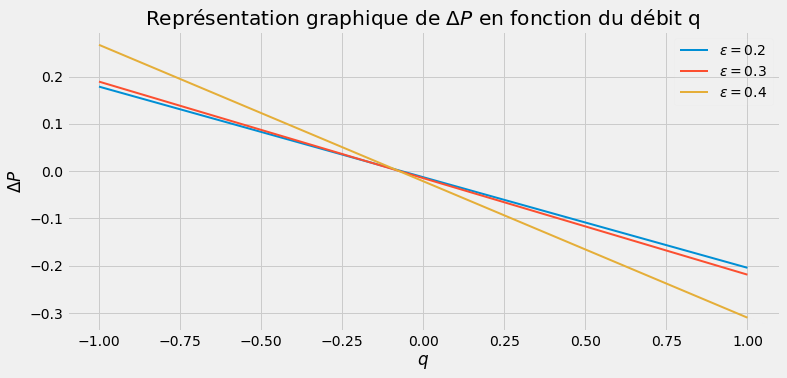

In [142]:
with plt.style.context('fivethirtyeight'):
#     plt.plot(qs, delta_p_1, linewidth=2, label=r'$\epsilon=0.1$')
    plt.plot(qs, delta_p_2, linewidth=2, label=r'$\epsilon=0.2$')
    plt.plot(qs, delta_p_3, linewidth=2, label=r'$\epsilon=0.3$')
    plt.plot(qs, delta_p_4, linewidth=2, label=r'$\epsilon=0.4$')
#     plt.plot(qs, delta_p_8, linewidth=2, label=r'$\epsilon=0.8$')

    plt.xlabel('$q$')
    plt.ylabel('$\Delta P$')
    plt.tight_layout()
    fig = plt.gcf()
    fig.set_size_inches(12.5, 5.5)
    plt.legend(framealpha=0.1)
    plt.title('Représentation graphique de $\Delta P$ en fonction du débit q')
    plt.savefig('figs/newtonian-pressure-drop-beta-small.png', transparent=True, dpi=100)

In [143]:
# M=0 (No magnetic field)
def a7(z=0.5, phi=phi):
    _r2 = r2(z=z, phi=phi)
    part_1 = np.math.pow(_r2, 2) * np.log(_r2)
    part_2 = np.math.pow(r1, 2) * np.log(r1)
    return (part_2 - part_1) / 2

@np.vectorize
def f(z=0.5, t=1, phi=phi):
    _r2 = r2(z=z, phi=phi)
    part_1 = (np.math.pow(_r2, 4) - np.math.pow(r1, 4)) / 8
    part_2 = a5(z=z, phi=phi, M=0, m=0) * np.math.pow(r1, 2) / 2
    part_3 = a5(z=z, phi=phi, M=0, m=0) * np.math.pow(np.log(_r2/ r1), -1)
    part_4 = a7(z=z, phi=phi) - a5(z=z, phi=phi, M=0, m=0) * (0.5 - np.log(_r2))
    return part_1 - part_2 - part_3 * part_4

@np.vectorize
def dpdz_(z=0.5, t=1, phi=phi, omega=omega, q0=q0, q1=q1, q_v=None):
    if not q_v:
        q_v = q(t, omega=omega, q0=q0, q1=q1)
    part_1 = q_v / (2 * pi)
    part_2 = a5(z=z, phi=phi, M=0, m=0)
    return -(part_1 + part_2) * np.math.pow(f(z=z, t=t, phi=phi), -1)

In [146]:
nz = 10
nt = 100
zs = np.linspace(0, 1, nz)
ts = np.linspace(0, 2, nt)
dps_ = np.zeros((nz, nt))

for (i, ti) in enumerate(ts):
    dps_[:,i] = dpdz_(z=zs, t=ti)

In [147]:
dfp_ = pd.DataFrame(dps_).transpose()
dfp_.head(2)

,0,1,2,3,4,5,6,7,8,9
0,-2.013562,-2.213745,-2.900276,-4.246619,-5.827269,-5.827269,-4.246619,-2.900276,-2.213745,-2.013562
1,-2.295182,-2.543224,-3.408719,-5.153258,-7.250429,-7.250429,-5.153258,-3.408719,-2.543224,-2.295182


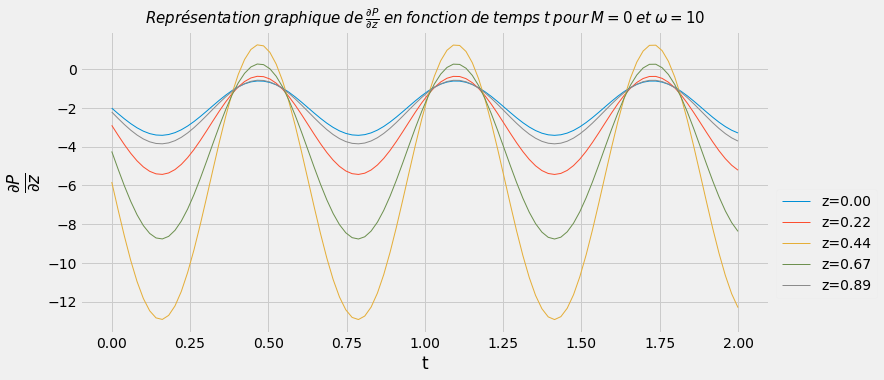

In [148]:
with plt.style.context('fivethirtyeight'):
    for i in np.arange(0, nz, 2):
        z = zs[i]
        plt.plot(ts, dps_[i, :], label=f'z={z:.2f}', linewidth=1)
    plt.legend(framealpha=0.1, bbox_to_anchor=(1, 0.5))
    fig = plt.gcf()
    fig.set_size_inches(12.5, 5.5)
    frac = r'\frac{\partial P}{\partial z}'
    plt.xlabel('t')
    plt.ylabel(f'${frac}$', fontsize=24)
    sp = r'\hspace{0.25}'
    t = fr'$Représentation{sp}graphique{sp}de{sp}{frac}{sp}en{sp}fonction{sp}de{sp}temps{sp}t{sp}pour{sp}M=0{sp}et{sp}\omega=10$'
    plt.title(t, fontsize=15)
    plt.tight_layout()
#     plt.savefig('figs/pressure-gradient-newtonian-beta-small-no-hartmann.png', transparent=True)

In [153]:
@np.vectorize
def c1_(z=0.5, t=1, phi=phi, q0=q0, q1=q1, omega=omega, q_v=None):
    part_1 = -a5(z, phi=phi) 
    part_2 = dpdz_(z=z, t=t, phi=phi, omega=omega, q0=q0, q1=q1, q_v=q_v)
    part_3 = np.log(r2(z=z, phi=phi) / r1)
    return  part_1 * part_2 * np.math.pow(part_3, -1)

@np.vectorize
def c2_(z=0.5, t=1, phi=phi, q0=q0, q1=q1, omega=omega, q_v=None):
    part_1 = np.math.pow(r1, 2) * dpdz_(z=z, t=t, phi=phi, omega=omega, q0=q0, q1=q1, q_v=q_v) / 2
    part_2 = c1_(z=z, t=t, phi=phi, q0=q0, q1=q1, omega=omega, q_v=q_v) * np.log(r1)
    return -1 - part_1 - part_2

@np.vectorize
def w_(r, z=0.5, t=1, phi=phi, q0=q0, q1=q1, omega=omega, q_v=None):
    part_1 = dpdz_(z=z, t=t, phi=phi, omega=omega, q0=q0, q1=q1, q_v=q_v) * np.math.pow(r, 2) / 2
    part_2 = c1_(z=z, t=t, phi=phi, q0=q0, q1=q1, omega=omega, q_v=q_v) * np.log(r)
    part_3 = c2_(z=z, t=t, phi=phi, q0=q0, q1=q1, omega=omega, q_v=q_v)
    return part_1 + part_2 + part_3

In [154]:
nr = 50
nt = 10
rs = np.linspace(r1, r2(), nr)
ts = np.linspace(0, 10, nt)
ws_ = np.zeros((50, 50))

for (i, ti) in enumerate(ts):
    ws_[:, i] = w_(r=rs, t=ti)

In [155]:
dfw_ = pd.DataFrame(ws_).transpose()
dfw_.head(2)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-1.0,-0.987942,-0.976485,-0.965620,-0.955340,-0.945635,-0.936497,-0.927920,-0.919896,-0.912416,...,-0.920682,-0.927926,-0.935569,-0.943607,-0.952038,-0.960860,-0.970069,-0.979664,-0.989642,-1.0
1,-1.0,-1.002797,-1.005454,-1.007975,-1.010359,-1.012610,-1.014730,-1.016719,-1.018581,-1.020316,...,-1.018398,-1.016718,-1.014945,-1.013081,-1.011125,-1.009079,-1.006943,-1.004717,-1.002403,-1.0


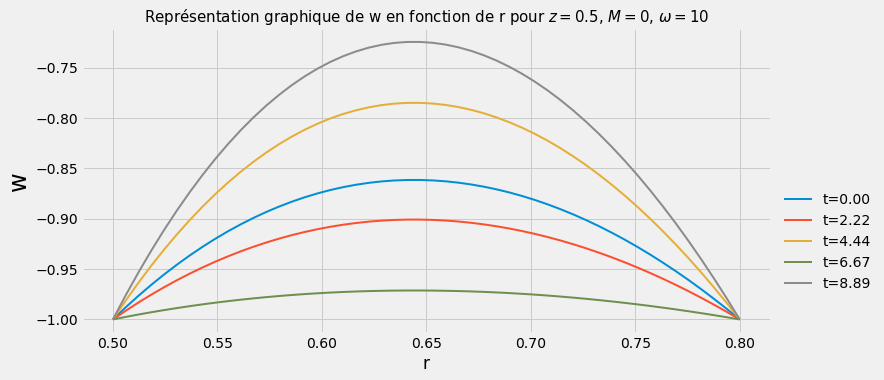

In [157]:
with plt.style.context('fivethirtyeight'):
    for i in range(5):
        t = ts[i * 2]
        plt.plot(rs, ws_[:, i * 2], label=f't={t:.2f}', linewidth=2)

    fig = plt.gcf()
    fig.set_size_inches(12.5, 5.5)
    plt.legend(framealpha=0.1, bbox_to_anchor=(1, 0.5))
    plt.xlabel('r')
    plt.ylabel('w', fontsize=24)
    
    t = r'Représentation graphique de w en fonction de r pour $z=0.5$, $M=0$, $\omega=10$'
    plt.title(t, fontsize=15)
    plt.tight_layout()
    plt.savefig('figs/axial-velocity-newtonian-beta-small-no-hartmann.png', transparent=True)

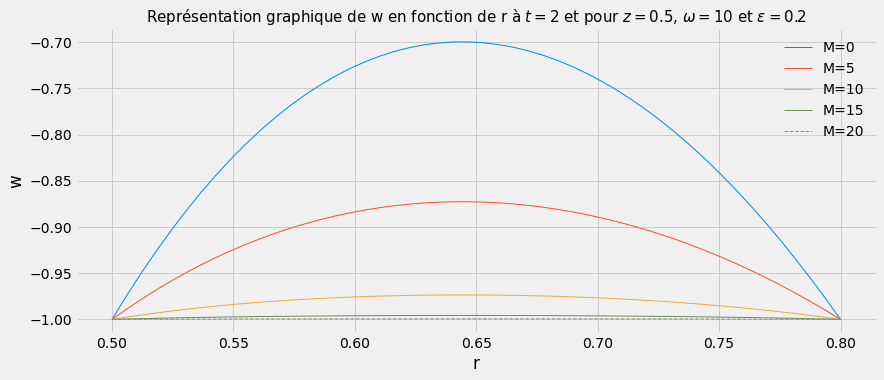

In [181]:
with plt.style.context('fivethirtyeight'):
    plt.plot(rs, ws_[:, 3], linewidth=1, label='M=0')
    plt.plot(rs, ws_1, linewidth=1, label='M=5')
    plt.plot(rs, ws_2, linewidth=1, label='M=10')
    plt.plot(rs, ws_3, linewidth=1, label='M=15')
    plt.plot(rs, ws_4, linewidth=1, label='M=20', linestyle='dashed')
    plt.legend(framealpha=0.1)
    
    fig = plt.gcf()
    fig.set_size_inches((12.5, 5.5))
    
    plt.xlabel('r')
    plt.ylabel('w')
    plt.title('Représentation graphique de w en fonction de r à $t=2$ et pour $z=0.5$, $\omega=10$ et $\epsilon=0.2$', fontsize=15)
    
    plt.tight_layout()
    plt.savefig('figs/axial-velocity-newtonian-beta-small-Hartmann-0.png', transparent=True)